In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms


import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning

In [2]:
reload(pcu)
reload(binning)
reload(filters)

<module 'filters' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/filters.py'>

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [4]:
def loadRawContactDirectory(dirpath, filetags, verbose=True):
    """A function to load a directory of contact tables"""
    results = {}
    for runId in filetags:
        df = pcu.loadContactTable(dirpath, runId)
        
        if verbose:
            print(f"{runId=} {df.shape=}")
        
        results[runId] = df
    return results
    
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
filetags = [f"run0{x}" for x in range(1, 8)]
rawCells = loadRawContactDirectory(dirpath, filetags)

print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run03' df.shape=(18685242, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


In [15]:
rawCells['run01'].columns

Index(['read_name', 'read_length', 'read_idx', 'contact_is_direct',
       'contact_is_cis', 'contact_read_distance', 'contact_genome_distance',
       'contact_fragment_adjacent', 'contact_fragment_distance',
       'haplotype_pair_type', 'align1_align_idx', 'align1_chrom',
       'align1_start', 'align1_end', 'align1_strand', 'align1_mapping_quality',
       'align1_align_score', 'align1_align_base_qscore', 'align1_phase_set',
       'align1_phase_qual', 'align1_haplotype', 'align1_fragment_id',
       'align1_fragment_start', 'align1_fragment_end', 'align2_align_idx',
       'align2_chrom', 'align2_start', 'align2_end', 'align2_strand',
       'align2_mapping_quality', 'align2_align_score',
       'align2_align_base_qscore', 'align2_phase_set', 'align2_haplotype',
       'align2_fragment_id', 'align2_fragment_start', 'align2_fragment_end',
       'batch_id'],
      dtype='object')

In [16]:
reload(pcu)
reload(binning)
reload(filters)

def runAllFilters(cells, assembly, chromosome='NC_000068.8', verbose=True):
    """A function to filter all cells """
    
    results = {}
    
    for runId, df in cells.items():
        
        cellFrame = cells[runId].copy()
        
        if chromosome is not None:
            cellFrame = filters.chromosomalFilter(cellFrame, assembly)
            cellFrame = filters.removeYChrom(cellFrame)
            cellFrame = pcu.filterChomosome(cellFrame, chromosome)
        
        if verbose:
            print("------------------------------")
            print(f"{runId=}")
    
#         cellFrame = filters.adjacentContactFilter(cellFrame)
        cellFrame = filters.selfLoopFilter(cellFrame)
        cellFrame = filters.mapQFilter(cellFrame, lowerBound=30, upperBound=250)
        cellFrame = filters.distalContactFilter(cellFrame)
        cellFrame = filters.closeContactFilter(cellFrame)
        cellFrame = filters.duplicateContactFilter(cellFrame, retain=1)
        cellFrame = filters.ligationProductFilter(cellFrame, nProducts=4, verbose=False)

#         cellFrame = filters.establishContactSupport(cellFrame, 
#                                              radiusThreshold=1000000, # 0.5 MB
#                                              nContacts=2, 
#                                              readSupport=False, 
#                                              nReads=3,
#                                              method=2)
#         if verbose:
#             print(f"{cellFrame['contact_has_support'].value_counts()=}")
            
#         cellFrame = filters.supportedContactFilter(cellFrame, readSupport=False)
        
        if verbose:
            res = pcu.getSummary(cellFrame)
            pcu.printSummary(res)
            print()
            
        results[runId] = cellFrame
        
    return results
    

filteredCellsChr2 = runAllFilters(rawCells,
                                  assembly, 
                                  chromosome='NC_000068.8', 
                                  verbose=True)  

print(f"{filteredCellsChr2.keys()=}")

------------------------------
runId='run01'
Total Reads 1902 (1.000)
Singletons 1310 (0.689)
Pairs 266 (0.140)
Multiway 326 (0.171)
-- -- --
Total Contacts 3359 (1.000)
cis Contacts 3359 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 3359 (1.000)
Direct Contacts 1194 (0.355)
Indirect Contacts 2165 (0.645)

------------------------------
runId='run02'
Total Reads 1092 (1.000)
Singletons 721 (0.660)
Pairs 173 (0.158)
Multiway 198 (0.181)
-- -- --
Total Contacts 1981 (1.000)
cis Contacts 1981 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 1981 (1.000)
Direct Contacts 666 (0.336)
Indirect Contacts 1315 (0.664)

------------------------------
runId='run03'
Total Reads 205 (1.000)
Singletons 134 (0.654)
Pairs 34 (0.166)
Multiway 37 (0.180)
-- -- --
Total Contacts 358 (1.000)
cis Contacts 358 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 358 (1.000)
Direct Contacts 128 (0.358)
Indirect Contacts 230 (0.642)

------------------------------
runId='run04'
Total Rea

In [6]:
# make interaction networks
reload(pcu)
reload(binning)

chomosome = 2
chromLength = assembly['Total length'].tolist()[0]

resolution = 1000000 # 1mb scale
chr2Bins = binning.getBins(chromLength, resolution)
label1 = 'bin1'
label2 = 'bin2'

matrices = {}

for runId, chr2 in filteredCellsChr2.items():
    print(f"{runId=}")
    
    chr2 = binning.chromosomeBinData(chr2, 
                                     chr2Bins, 
                                     label1=label1, 
                                     label2=label2)
    
    A = pcu.getHic(chr2, chr2Bins, label1, label2)
    print(f"{A.shape}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01'
(196, 196)
runId='run02'
(196, 196)
runId='run03'
(196, 196)
runId='run04'
(196, 196)
runId='run05'
(196, 196)
runId='run06'
(196, 196)
runId='run07'
(196, 196)
dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


In [7]:
matrices['run01']

bin2,1,2,3,4,5,6,7,8,9,10,...,187,188,189,190,191,192,193,194,195,196
bin1,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,159.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,203.0,86.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,14.0,86.0,141.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,11.0,0.0,237.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0
194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


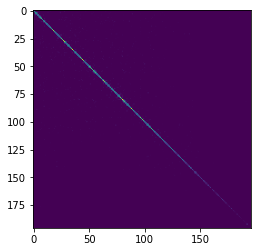

In [8]:
plt.imshow(matrices['run01'])

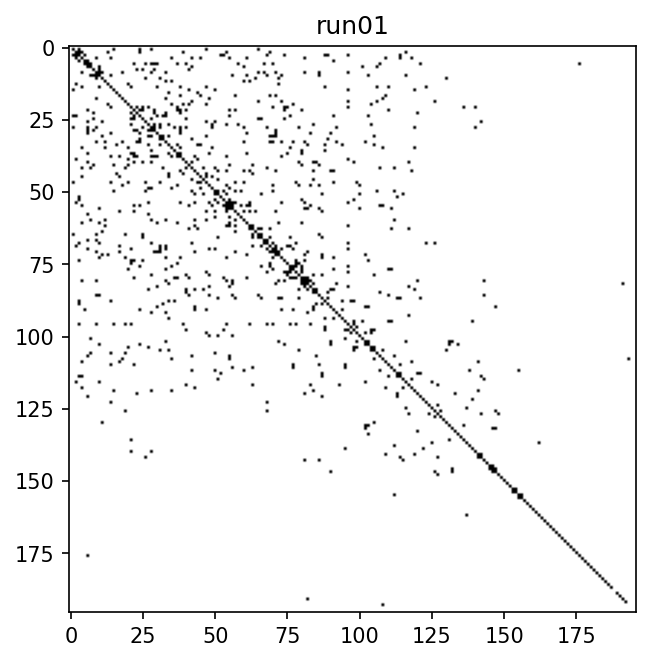

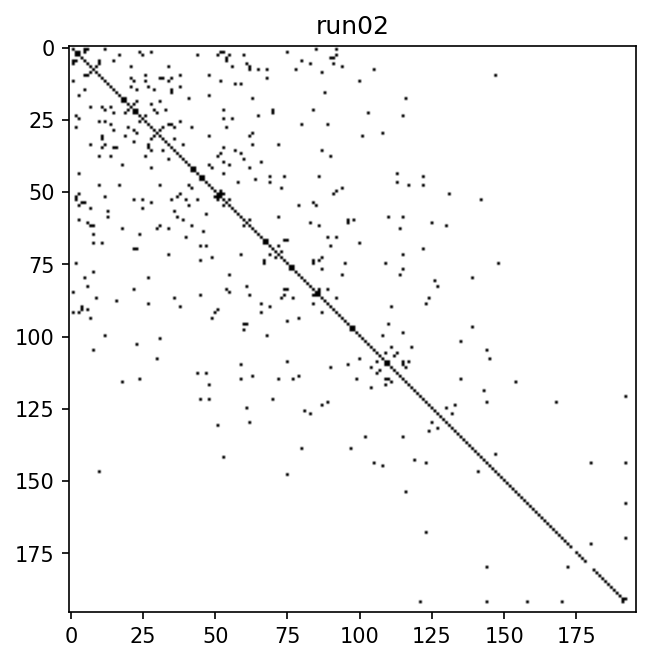

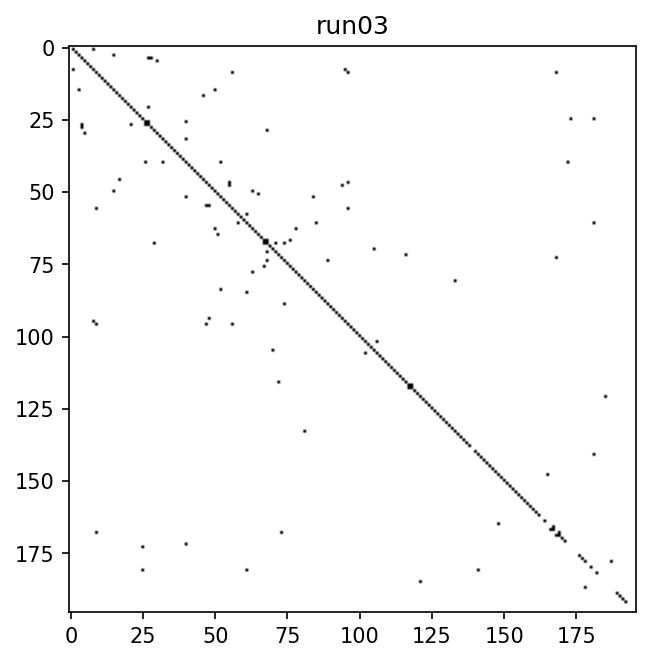

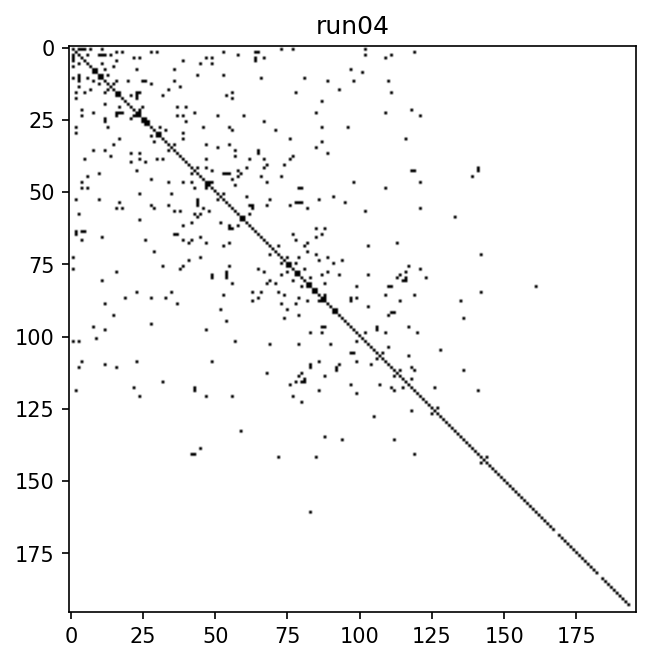

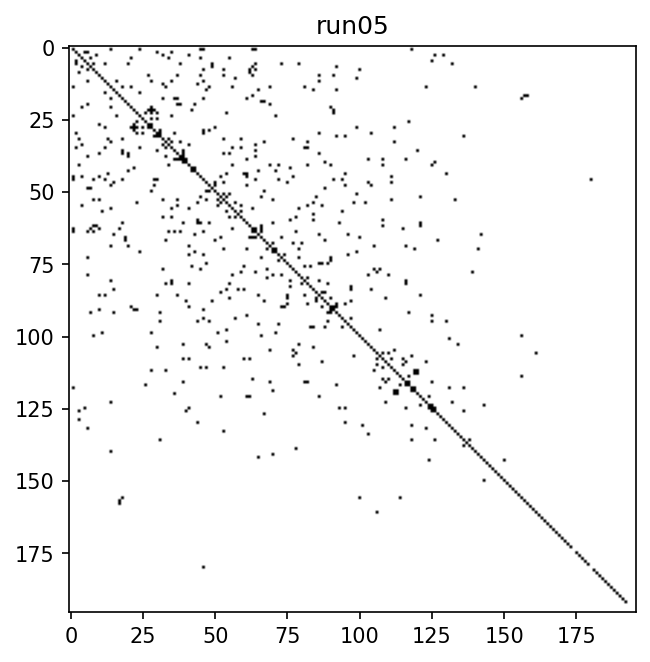

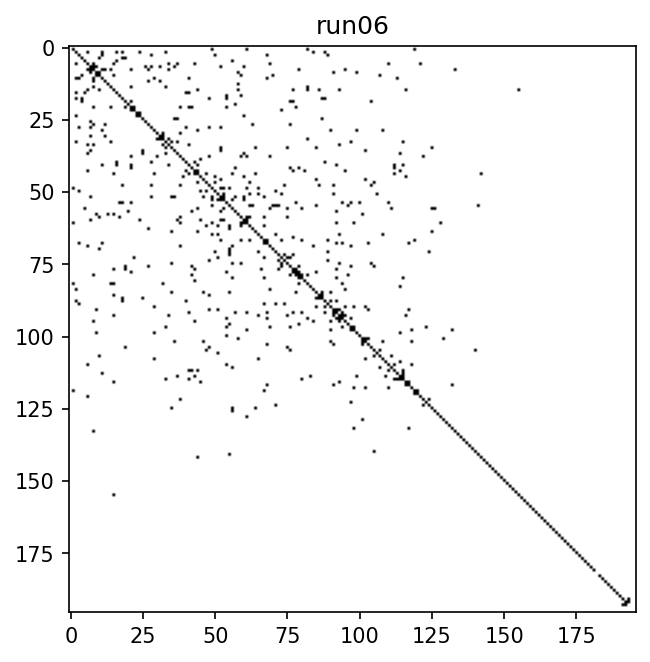

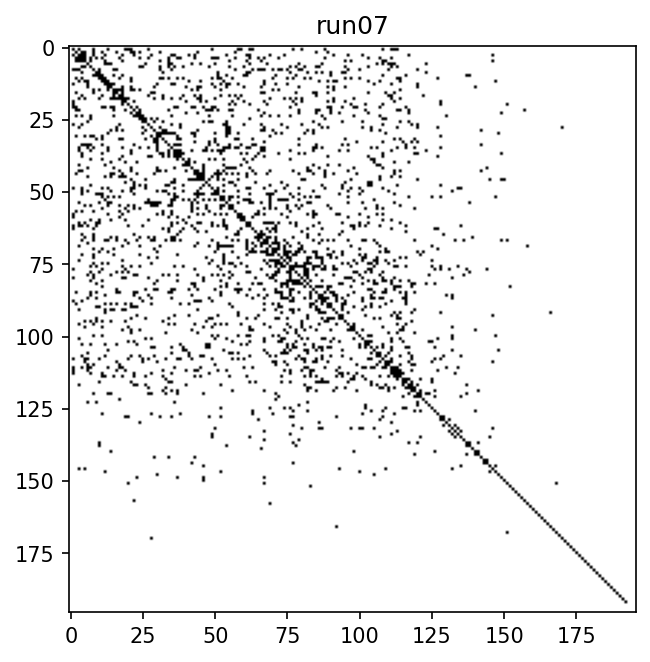

In [9]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 5, 5

for runId, A in matrices.items():
    
    Abinary = np.where(A > 0, 1, 0)
    plt.imshow(Abinary, cmap='binary')
    plt.title(runId)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [10]:

    
    
    
# robustContactMatrix(filteredCellsChr2, chr2Bins, 
#                     label1, 
#                     label2)
    
    